In [34]:
from cgr_model import TwinModel
# also import the functions for testing different means of transferring ArabidopsisPPI results to EffectorPPI 
from cgr_model import test_mode_no_retraining, test_mode_retraining, test_mode_train_from_scratch
import numpy as np
import random
import tensorflow as tf
from os.path import exists
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
from scipy.stats import rankdata

Get best-performing ArabidopsisPPI parameter sets for k=4

In [10]:
arabidopsis_results_folder = 'data/0003_results_of_ppi_prediction_parameter_search/Arabidopsis_thaliana'

k=4
means=np.zeros((1000,1))
for seed_i in range(1000):
    out_filename = f'{arabidopsis_results_folder}/AtGrand_{k}mers_{seed_i}.csv'
    if exists(out_filename):
        results = pd.read_csv(out_filename)
        means[seed_i] = np.mean(results['max_val_acc'])

In [14]:
inds = np.argsort(means,axis=0)[::-1]

In [16]:
# Top 10 parameter sets
inds[:10]

array([[881],
       [385],
       [856],
       [777],
       [481],
       [692],
       [212],
       [869],
       [670],
       [130]])

In [17]:
# checkpoints for the top 10 models according to validation accuracy on the ArabidopsisPPI dataset
arabidopsis_checkpoints_folder = 'data/0000_model_checkpoints'

In [21]:
# EffectorK 4mer data
data_file='data/0000_datasets_as_used_in_paper/EffectorK/EffK4mers.npz'

Load results used in paper:

In [23]:
all_results_retrained_freeze=pd.read_csv('data/0004_effectorppi_transfer_learning/output_folder/holdout_retrained_freeze.csv')
all_results_from_scratch=pd.read_csv('data/0004_effectorppi_transfer_learning/output_folder/holdout_trained_from_scratch.csv')
all_results_retrained=pd.read_csv('data/0004_effectorppi_transfer_learning/output_folder/holdout_retrained.csv')

...Or rerun:

In [ ]:
new_checkpoint_folder='data/0004_effectorppi_transfer_learning/new_checkpoints'

# Use only the hyperparameters without loading the models trained on ArabidopsisPPI
all_results_from_scratch=[]
for seed_i in inds[:10]:
    i = seed_i[0]
    # load in existing results and create parameter dictionary
    out_filename = f'{arabidopsis_results_folder}/AtGrand_{k}mers_{i}.csv'
    out_df = pd.read_csv(out_filename)
    params = out_df.iloc[0][1:26].to_dict()
    # get results
    results = test_mode_train_from_scratch(params, i, data_file, new_checkpoint_folder)
    all_results_from_scratch.append(results)
pd.concat(all_results_from_scratch).to_csv('data/0004_effectorppi_transfer_learning/output_folder/holdout_trained_from_scratch.csv')


# Load the models trained on ArabidopsisPPI, then train further on EffectorPPI
all_results_retrained=[]
for seed_i in inds[:10]:
    i = seed_i[0]
    # load in existing results and create parameter dictionary
    out_filename = f'{arabidopsis_results_folder}/AtGrand_{k}mers_{i}.csv'
    out_df = pd.read_csv(out_filename)
    params = out_df.iloc[0][1:26].to_dict()
    # get results
    results = test_mode_retraining(params, i, data_file, 
                                   arabidopsis_checkpoints_folder, new_checkpoint_folder
                                   head_only=False)
    all_results_retrained.append(results)
pd.concat(all_results_retrained).to_csv('data/0004_effectorppi_transfer_learning/output_folder/holdout_retrained.csv')


# Load the models trained on ArabidopsisPPI, freeze all but the final classifier layer, then train further on EffectorPPI
all_results_retrained_freeze=[]
for seed_i in inds[:10]:
    i = seed_i[0]
    # load in existing results and create parameter dictionary
    out_filename = f'{arabidopsis_results_folder}/AtGrand_{k}mers_{i}.csv'
    out_df = pd.read_csv(out_filename)
    params = out_df.iloc[0][1:26].to_dict()
    # get results
    results = test_mode_retraining(params, i, data_file, 
                                   arabidopsis_checkpoints_folder, new_checkpoint_folder
                                   head_only=True)
    all_results_retrained_freeze.append(results)
pd.concat(all_results_retrained_freeze).to_csv('data/0004_effectorppi_transfer_learning/output_folder/holdout_retrained_freeze.csv')

In [30]:
all_results_from_scratch['method']='From scratch'
all_results_retrained['method']='Retrained'
all_results_retrained_freeze['method']='Retrained (head only)'

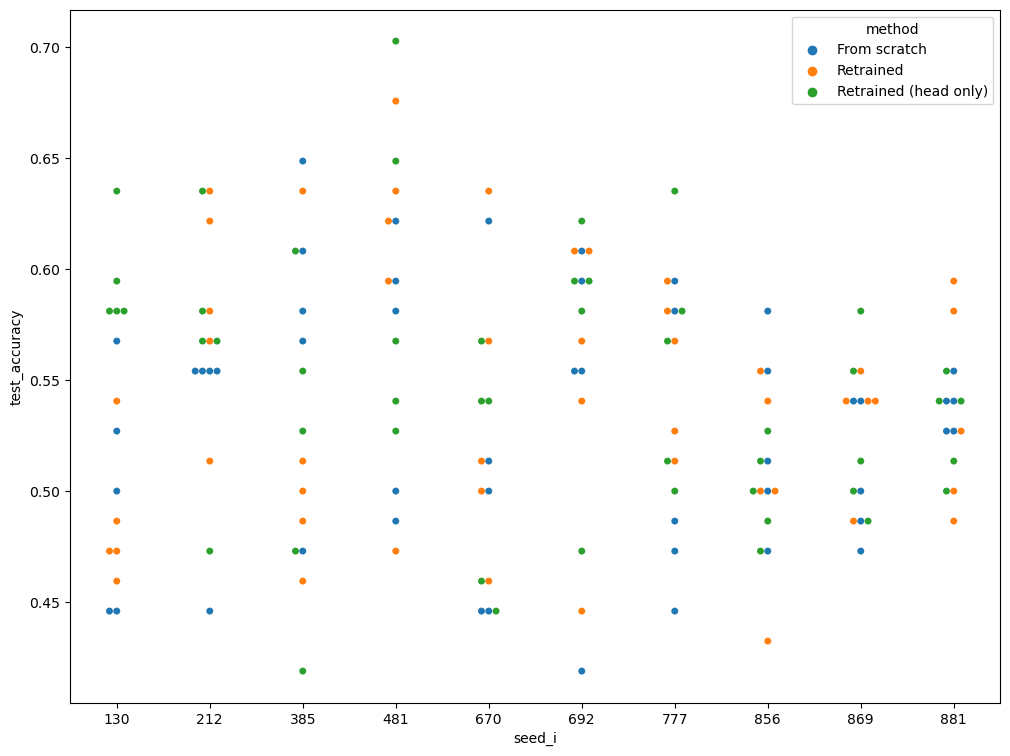

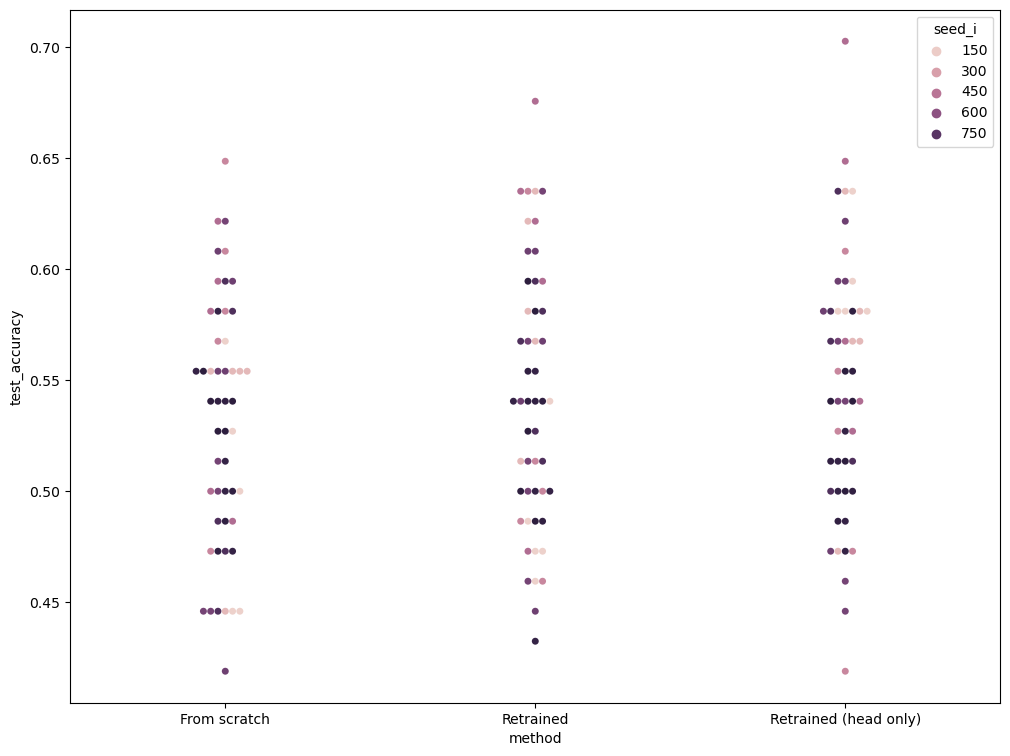

In [31]:
plt.figure(figsize=(12,9))
sb.swarmplot(data=pd.concat((all_results_from_scratch, all_results_retrained, all_results_retrained_freeze)),y='test_accuracy',x='seed_i',hue='method')
plt.show()
plt.figure(figsize=(12,9))
sb.swarmplot(data=pd.concat((all_results_from_scratch, all_results_retrained, all_results_retrained_freeze)),y='test_accuracy',x='method',hue='seed_i')
plt.show()

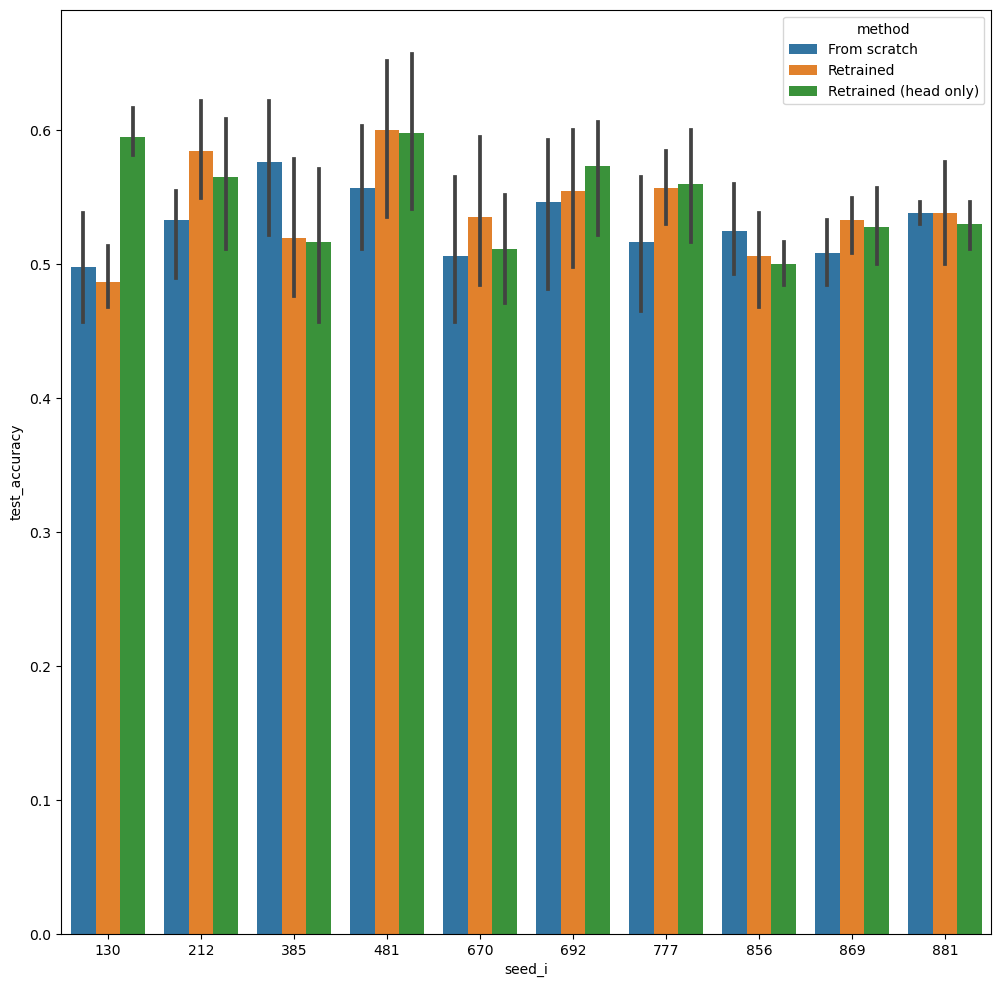

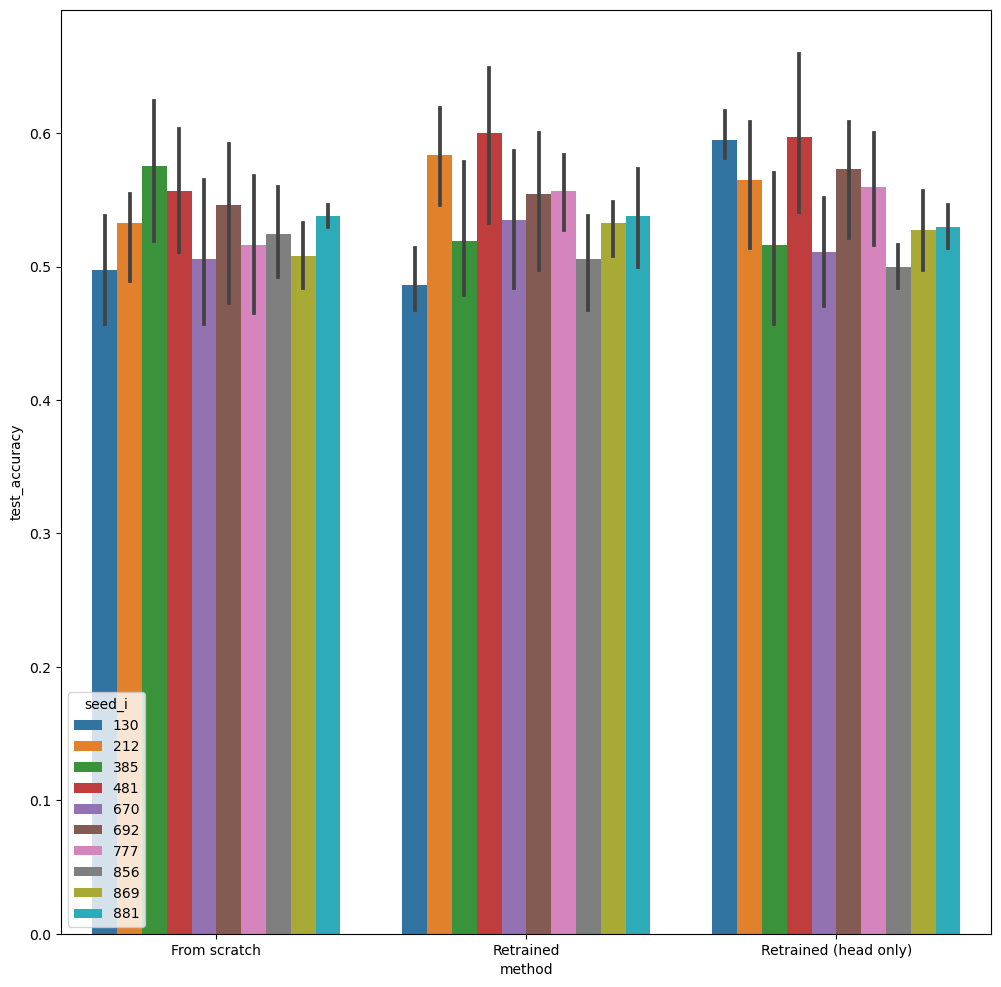

In [32]:
plt.figure(figsize=(12,12))
sb.barplot(data=pd.concat((all_results_from_scratch, all_results_retrained, all_results_retrained_freeze)),y='test_accuracy',x='seed_i',hue='method')
plt.show()

plt.figure(figsize=(12,12))
sb.barplot(data=pd.concat((all_results_from_scratch, all_results_retrained, all_results_retrained_freeze)),y='test_accuracy',x='method',hue='seed_i')
plt.show()

In [35]:
tbl = []
for seed_i in np.unique(all_results_from_scratch['seed_i']):
    mean_scratch = all_results_from_scratch.query(f'seed_i=={seed_i}')['test_accuracy'].mean()
    mean_retrained = all_results_retrained.query(f'seed_i=={seed_i}')['test_accuracy'].mean()
    mean_freeze = all_results_retrained_freeze.query(f'seed_i=={seed_i}')['test_accuracy'].mean()
    ranks=rankdata([mean_scratch, mean_retrained, mean_freeze],method='min')
    tbl.append([seed_i,
                np.round(mean_scratch,decimals=3),
                np.round(all_results_from_scratch.query(f'seed_i=={seed_i}')['test_accuracy'].std(),decimals=3),
                np.round(all_results_from_scratch.query(f'seed_i=={seed_i}')['test_accuracy'].min(),decimals=3),
                np.round(all_results_from_scratch.query(f'seed_i=={seed_i}')['test_accuracy'].max(),decimals=3),
                ranks[0],
                np.round(mean_retrained,decimals=3),
                np.round(all_results_retrained.query(f'seed_i=={seed_i}')['test_accuracy'].std(),decimals=3),
                np.round(all_results_retrained.query(f'seed_i=={seed_i}')['test_accuracy'].min(),decimals=3),
                np.round(all_results_retrained.query(f'seed_i=={seed_i}')['test_accuracy'].max(),decimals=3),
                ranks[1],
                np.round(mean_freeze,decimals=3),
                np.round(all_results_retrained_freeze.query(f'seed_i=={seed_i}')['test_accuracy'].std(),decimals=3),
                np.round(all_results_retrained_freeze.query(f'seed_i=={seed_i}')['test_accuracy'].min(),decimals=3),
                np.round(all_results_retrained_freeze.query(f'seed_i=={seed_i}')['test_accuracy'].max(),decimals=3),
                ranks[2]
                ])
tbl_df=pd.DataFrame(tbl, columns=['seed','From scratch (mean)','From scratch (std)','From scratch (min)','From scratch (max)','From scratch (rank)',
                          'Retrained (mean)','Retrained (std)','Retrained (min)','Retrained (max)','Retrained (rank)',
                          'Retrained - head only (mean)','Retrained - head only (std)','Retrained - head only (min)',
                          'Retrained - head only (max)','Retrained - head only (rank)'])

In [38]:
tbl_df

,seed,From scratch (mean),From scratch (std),From scratch (min),From scratch (max),From scratch (rank),Retrained (mean),Retrained (std),Retrained (min),Retrained (max),Retrained (rank),Retrained - head only (mean),Retrained - head only (std),Retrained - head only (min),Retrained - head only (max),Retrained - head only (rank)
0,130,0.497,0.053,0.446,0.568,2,0.486,0.032,0.459,0.541,1,0.595,0.023,0.581,0.635,3
1,212,0.532,0.048,0.446,0.554,1,0.584,0.048,0.514,0.635,3,0.565,0.058,0.473,0.635,2
2,385,0.576,0.065,0.473,0.649,3,0.519,0.068,0.459,0.635,2,0.516,0.073,0.419,0.608,1
3,481,0.557,0.060,0.486,0.622,1,0.600,0.077,0.473,0.676,3,0.597,0.075,0.527,0.703,2
4,670,0.505,0.072,0.446,0.622,1,0.535,0.068,0.459,0.635,3,0.511,0.054,0.446,0.568,2
5,692,0.546,0.075,0.419,0.608,1,0.554,0.067,0.446,0.608,2,0.573,0.058,0.473,0.622,3
6,777,0.516,0.067,0.446,0.595,1,0.557,0.035,0.514,0.595,2,0.559,0.055,0.500,0.635,3
7,856,0.524,0.043,0.473,0.581,3,0.505,0.047,0.432,0.554,2,0.500,0.021,0.473,0.527,1
8,869,0.508,0.031,0.473,0.541,1,0.532,0.026,0.486,0.554,3,0.527,0.039,0.486,0.581,2
9,881,0.538,0.011,0.527,0.554,2,0.538,0.048,0.486,0.595,3,0.530,0.022,0.500,0.554,1


In [42]:
methods = ['From scratch (mean)','Retrained (mean)','Retrained - head only (mean)']
wins = np.zeros((3,3))
for seed_i in np.unique(all_results_from_scratch['seed_i']):
    row = tbl_df.query(f'seed=={seed_i}').iloc[0]
    for i, method_1 in enumerate(methods):
        for j, method_2 in enumerate(methods):
            if row[method_1] > row[method_2]:
                wins[i,j]+=1
                print(f'{method_1} beats {method_2} on seed {seed_i}')

From scratch (mean) beats Retrained (mean) on seed 130
Retrained - head only (mean) beats From scratch (mean) on seed 130
Retrained - head only (mean) beats Retrained (mean) on seed 130
Retrained (mean) beats From scratch (mean) on seed 212
Retrained (mean) beats Retrained - head only (mean) on seed 212
Retrained - head only (mean) beats From scratch (mean) on seed 212
From scratch (mean) beats Retrained (mean) on seed 385
From scratch (mean) beats Retrained - head only (mean) on seed 385
Retrained (mean) beats Retrained - head only (mean) on seed 385
Retrained (mean) beats From scratch (mean) on seed 481
Retrained (mean) beats Retrained - head only (mean) on seed 481
Retrained - head only (mean) beats From scratch (mean) on seed 481
Retrained (mean) beats From scratch (mean) on seed 670
Retrained (mean) beats Retrained - head only (mean) on seed 670
Retrained - head only (mean) beats From scratch (mean) on seed 670
Retrained (mean) beats From scratch (mean) on seed 692
Retrained - hea

In [37]:
pd.DataFrame(wins,methods, columns=methods)

,From scratch (mean),Retrained (mean),Retrained - head only (mean)
From scratch (mean),0.0,3.0,3.0
Retrained (mean),6.0,0.0,7.0
Retrained - head only (mean),7.0,3.0,0.0
